# Lab 05 - Extended Exercises on Model Evaluation
## Predicting student performance

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler,  OneHotEncoder

# Data directory
DATA_DIR = "./../../data/"

In [2]:
import requests

exec(requests.get("https://courdier.pythonanywhere.com/get-send-code").content)

npt_config = {
    'session_name': 'lab-05',
    'session_owner': 'mlbd',
    'sender_name': input("Your name: "),
}

Your name:  Paola


## Introduction
The data has already been cleaned and it comes from 29 students in 3 different groups in a course of 26 weeks.

You already used this data in week 03. 

In this lab you will explore different models to predict the quiz grade. 

In [4]:
# Load data
df= pd.read_csv(f'{DATA_DIR}grades_in_time.csv.gz')
df.head()

,student,week,studying_hours,group,quiz_grade
0,0,0,39.9,3,6.1
1,0,1,32.4,3,7.0
2,0,2,17.5,3,6.9
3,0,3,16.0,3,7.0
4,0,4,15.9,3,7.2


In [5]:
df.describe(include='all')

,student,week,studying_hours,group,quiz_grade
count,810.000000,810.000000,810.000000,810.000000,810.000000
mean,14.500000,13.000000,10.050617,1.933333,6.931975
std,8.660789,7.793693,8.270041,0.772199,1.336888
min,0.000000,0.000000,1.000000,1.000000,1.200000
25%,7.000000,6.000000,5.700000,1.000000,6.400000
50%,14.500000,13.000000,7.800000,2.000000,7.200000
75%,22.000000,20.000000,11.100000,3.000000,7.800000
max,29.000000,26.000000,64.000000,3.000000,10.100000


# Task 1: Predict the quiz grade using the studying hours and the group.
----------
### 1.1 Split the data. 80% to train and the rest to test. 


In [ ]:
X = df[['studying_hours', 'group']]
y = df['quiz_grade']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)

### 1.2 Preprocess the data
Recall that group is a categorical feature.

Hint: Use ColumnTransformer.

In [62]:
preprocessor = ColumnTransformer([
    ('categorical', OneHotEncoder(handle_unknown='ignore', drop = 'first'), ['group']),
    ('numerical', MinMaxScaler(),['studying_hours'])
])

preprocessor.fit_transform(X_train)

array([[0.        , 0.        , 0.07482993],
       [0.        , 1.        , 0.13945578],
       [0.        , 0.        , 0.11904762],
       ...,
       [1.        , 0.        , 0.08333333],
       [0.        , 0.        , 0.30782313],
       [0.        , 1.        , 0.16156463]])

### 1.3 Create a pipeline (including the preprocessing steps) to predict the quiz grade using the studying hours and the group.

1. Use the model ElasticNet for the regression task.
2. Calculate the mean sqaured error of the prediction. 


Hint: Integrate the ColumnTransformer as a pipeline step

In [63]:
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', ElasticNet())
])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
error = round(mean_squared_error(y_test, y_pred),3)
print(f"Mean Squared Error = {error}")

Mean Squared Error = 1.582


### 1.4 Compute the cross validation score

In [64]:
# Fit a pipeline with transformers and an estimator to the training data
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', ElasticNet())
])

(-1)*np.mean(cross_val_score(pipe, X, y, cv = 5, scoring = 'neg_mean_squared_error'))

1.8575008478128328

### 1.5 Does the score in 1.3 differ from the score in 1.4? Why? 

Answer = 1.3 is one fold and 1.4 is the average of multiple folds.

### 1.6 What is wrong with data split?
Answer: We are using the future sometimes to predict the past

In [65]:
df.iloc[X_test.index][['week','student']]

,week,student
613,19,22
202,13,7
55,1,2
478,19,17
27,0,1
...,...,...
749,20,27
71,17,2
49,22,1
416,11,15


## Task 2: Time Validation

### 2.1 Train with the first 25 weeks and predict week 26.

Hint: You may re-use your pipeline

In [66]:
df_train = df.query('week < 26')
df_test = df.query('week == 26')

In [67]:
X_train = df_train[['studying_hours', 'group','week']]
y_train = df_train['quiz_grade']

X_test = df_test[['studying_hours', 'group','week']]
y_test = df_test['quiz_grade']

In [68]:
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
error = round(mean_squared_error(y_test, y_pred),3)
print(f"Mean Squared Error = {error}")

Mean Squared Error = 1.86


### 2.2 Time splits
Would the model also be able to predict week 16 from all the previous weeks? 

What about week 5 from the previous weeks?

Create all the data splits so that the model predicts the next week given the information from the previous weeks. 


In [69]:
time_splits = [tuple([list(df.query('week < @i').index), list(df.query('week == @i').index)]) for i in range(4,27)]

### 2.3 Using the previously created splits, calculate the cross validation score

In [70]:
X = df[['studying_hours', 'group']]
y = df['quiz_grade']

errors = (-1)*cross_val_score(pipe, X, y, cv = time_splits, scoring = 'neg_mean_squared_error')
np.mean(errors)

1.7933446924429217

### 2.4 How does the error differ from the error of 2.1? Why?
Answer = It is much higher. On the following plot we see that the more weeks (more information), the smaller the error

<AxesSubplot:>

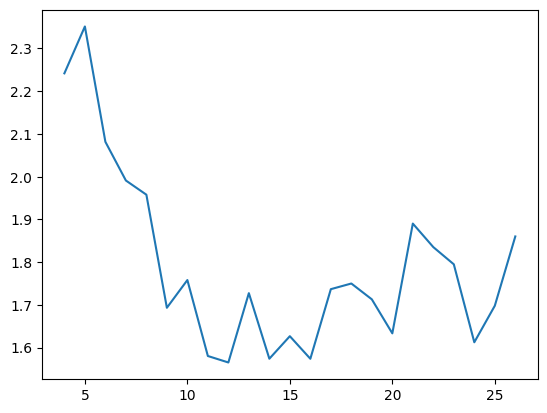

In [71]:
sns.lineplot(y = errors, x = list(range(4,27)))

## Task 3: Nested cross-validation

Now imagine we want to optimize the hyperparameters for the model.

We will "ignore" time for now and take the mean studying hours and quiz grade. 


In [72]:
df_agg = df.groupby('student').mean()

X = df_agg[['studying_hours', 'group']]
y = df_agg['quiz_grade']

### 3.1 Gridsearch with cross validation

ElasticNet has two interesting parameters: alpha and l1_ratio.

Run a GridSearch to explore the following values:
* alpha = 0.1 and 1
* l1_ratio = 0.1, 0.5 and 1

What is the best score (smallest error)? 

In [92]:
param_grid = {'model__alpha': [0.1, 1],
             'model__l1_ratio': [0.1, 0.5, 1]}

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv =  KFold(n_splits=4, shuffle=True, random_state=123) ,
                      scoring = 'neg_mean_squared_error')
search.fit(X,y)

GridSearchCV(cv=KFold(n_splits=4, random_state=123, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('categorical',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['group']),
                                                                        ('numerical',
                                                                         MinMaxScaler(),
                                                                         ['studying_hours'])])),
                                       ('model', ElasticNet())]),
             n_jobs=-1,
             param_grid={'model__alpha': [0.1, 1],
                         'model__l1_ratio': [0.1, 0.5, 1]},
             scor

In [93]:
pd.DataFrame(search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__alpha,param_model__l1_ratio,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,0.084765,0.040885,0.124522,0.042845,0.1,0.1,"{'model__alpha': 0.1, 'model__l1_ratio': 0.1}",-0.357376,-0.261542,-0.108918,-0.346856,-0.268673,0.099440,1
1,0.190319,0.072629,0.176377,0.086030,0.1,0.5,"{'model__alpha': 0.1, 'model__l1_ratio': 0.5}",-0.382699,-0.283716,-0.121981,-0.342687,-0.282771,0.099285,2
2,0.250369,0.046773,0.152884,0.110980,0.1,1,"{'model__alpha': 0.1, 'model__l1_ratio': 1}",-0.382699,-0.289399,-0.126909,-0.340410,-0.284854,0.096989,3
3,0.224204,0.042654,0.126463,0.106406,1,0.1,"{'model__alpha': 1, 'model__l1_ratio': 0.1}",-0.382699,-0.289399,-0.126909,-0.340410,-0.284854,0.096989,3
4,0.248766,0.049980,0.101051,0.065776,1,0.5,"{'model__alpha': 1, 'model__l1_ratio': 0.5}",-0.382699,-0.289399,-0.126909,-0.340410,-0.284854,0.096989,3
5,0.197975,0.066664,0.053716,0.045144,1,1,"{'model__alpha': 1, 'model__l1_ratio': 1}",-0.382699,-0.289399,-0.126909,-0.340410,-0.284854,0.096989,3


In [94]:
(-1)*search.best_score_

0.2686728849527697

### 3.2 Why is the error from the best model in 3.1 biased?

Answer = We are using the same data to tune model parameters and evaluate model performance.

### 3.3 Improve 3.1 to have an unbiased estimation of the generalization error

Hint: Use nested cross-validation

In [95]:
inner_cv = KFold(n_splits=4, shuffle=True, random_state=123)
outer_cv = KFold(n_splits=3, shuffle=True, random_state=123)
    
param_grid = {'model__alpha': [0.1, 1],
             'model__l1_ratio': [0.1, 0.5, 1]}

search = GridSearchCV(pipe, param_grid, n_jobs=-1, 
                      cv = inner_cv, scoring = 'neg_mean_squared_error')
errors = (-1)* cross_val_score(search, X=X, y=y,
                               cv=outer_cv)

np.mean(errors)

0.27392204035478573

In [96]:
errors

array([0.301807  , 0.266251  , 0.25370813])